# Carregando dataset

In [1]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
# PICKLE_PATH = 'Sunnybrook_Dataset/pickled_data/'
PICKLE_PATH = 'pickle/'
AUGMENTATION_PATH = 'Sunnybrook_Dataset/Data_Augmentation/'
MODEL_PATH = 'modelo/Attention'

In [2]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [3]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)


all_scans = list(map(converter_pixel_array_rgb, all_scans))

all_scans = np.array(all_scans)
# all_contours = np.array(all_contours)
all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)
# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)


# # converter para float
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

In [4]:
len(X_train), len(X_test), len(X_val)

(563, 161, 81)

In [5]:
Y_train.shape

(563, 256, 256, 1)

In [6]:
len(X_train), np.max(X_train)

(563, 1.0)

1.0


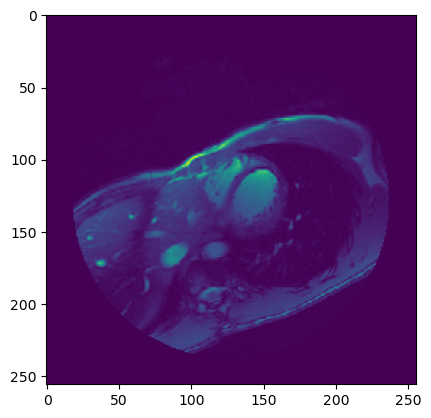

In [7]:
# print(Y_train[0][0])
print(np.max(X_train[0]))
plt.imshow(X_train[0])
plt.show()

In [8]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

# Metricas

In [9]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth))
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [10]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [11]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    
    # getting x to the same shape as the gating signal
    theta_x = Conv2D(inter_shape,(2,2), strides=(2,2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    
    # getting the gating signal to the same nunmber of filters as the inter_shape
    phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)
    
    upsample_g = Conv2DTranspose(inter_shape, (3,3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)
    
    concat_xg = add([upsample_g, theta_x])
    
    act_xg = Activation('relu')(concat_xg)
    
    psi = Conv2D(1, (1,1), padding='same')(act_xg)
    
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    result = Conv2D(shape_x[3], (1,1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    
    return result_bn

In [12]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2D(512, (1, 1), padding='same')(c5)
u6 = Activation('relu')(u6)
u6 = attention_block(c4, u6, 512)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2D(512, (1, 1), padding='same')(c6)
u7 = Activation('relu')(u7)
u7 = attention_block(c3, u7, 256)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2D(512, (1, 1), padding='same')(c7)
u8 = Activation('relu')(u8)
u8 = attention_block(c2, u8, 128)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2D(512, (1, 1), padding='same')(c8)
u9 = Activation('relu')(u9)
u9 = attention_block(c1, u9, 64)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH + '.h5', verbose=1, save_weights_only=True)

callbacks = [checkpoint,
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [14]:
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=25, callbacks=callbacks)
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=100,
                    callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)
json_model = model.to_json()
open(MODEL_PATH + '.json', 'w').write(json_model)
model.save_weights(MODEL_PATH + '.h5', overwrite=True)

# save:
f = open(MODEL_PATH + '.pckl', 'wb')
pickle.dump(results.history, f)
f.close()

C:\Users\Margeo\anaconda3\envs\TCC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
56/56 [==============================] - 77s 729ms/step - loss: 0.1697 - accuracy: 0.9561 - dicemon: 0.0535 - jaccardmon: 0.0261 - val_loss: 0.2780 - val_accuracy: 0.9809 - val_dicemon: 0.0521 - val_jaccardmon: 0.0263

Epoch 00001: saving model to modelo\Attention.h5
Epoch 2/100
56/56 [==============================] - 31s 556ms/step - loss: 0.0656 - accuracy: 0.9820 - dicemon: 0.0732 - jaccardmon: 0.0338 - val_loss: 0.1874 - val_accuracy: 0.9809 - val_dicemon: 0.0688 - val_jaccardmon: 0.0353

Epoch 00002: saving model to modelo\Attention.h5
Epoch 3/100
56/56 [==============================] - 31s 561ms/step - loss: 0.0648 - accuracy: 0.9820 - dicemon: 0.0745 - jaccardmon: 0.0348 - val_loss: 0.1455 - val_accuracy: 0.9809 - val_dicemon: 0.0979 - val_jaccardmon: 0.0510

Epoch 00003: saving model to modelo\Attention.h5
Epoch 4/100
56/56 [==============================] - 32s 561ms/step - loss: 0.0629 - accuracy: 0.9820 - dicemon: 0.0837 - jaccardmon: 0.0390 - val_loss: 0.0966 

56/56 [==============================] - 31s 556ms/step - loss: 0.0553 - accuracy: 0.9820 - dicemon: 0.1468 - jaccardmon: 0.0712 - val_loss: 0.0679 - val_accuracy: 0.9809 - val_dicemon: 0.0920 - val_jaccardmon: 0.0422

Epoch 00030: saving model to modelo\Attention.h5
Epoch 31/100
56/56 [==============================] - 31s 554ms/step - loss: 0.0555 - accuracy: 0.9821 - dicemon: 0.1450 - jaccardmon: 0.0704 - val_loss: 0.0640 - val_accuracy: 0.9809 - val_dicemon: 0.1027 - val_jaccardmon: 0.0492

Epoch 00031: saving model to modelo\Attention.h5
Epoch 32/100
56/56 [==============================] - 31s 558ms/step - loss: 0.0551 - accuracy: 0.9821 - dicemon: 0.1485 - jaccardmon: 0.0719 - val_loss: 0.0638 - val_accuracy: 0.9809 - val_dicemon: 0.1053 - val_jaccardmon: 0.0494

Epoch 00032: saving model to modelo\Attention.h5
Epoch 33/100
56/56 [==============================] - 31s 558ms/step - loss: 0.0549 - accuracy: 0.9821 - dicemon: 0.1489 - jaccardmon: 0.0725 - val_loss: 0.0857 - val_acc

56/56 [==============================] - 31s 555ms/step - loss: 0.0521 - accuracy: 0.9822 - dicemon: 0.1832 - jaccardmon: 0.0910 - val_loss: 0.0617 - val_accuracy: 0.9810 - val_dicemon: 0.1466 - val_jaccardmon: 0.0712

Epoch 00059: saving model to modelo\Attention.h5
Epoch 60/100
56/56 [==============================] - 31s 558ms/step - loss: 0.0520 - accuracy: 0.9823 - dicemon: 0.1844 - jaccardmon: 0.0919 - val_loss: 0.0676 - val_accuracy: 0.9810 - val_dicemon: 0.1210 - val_jaccardmon: 0.0576

Epoch 00060: saving model to modelo\Attention.h5
Epoch 61/100
56/56 [==============================] - 31s 558ms/step - loss: 0.0518 - accuracy: 0.9823 - dicemon: 0.1868 - jaccardmon: 0.0928 - val_loss: 0.0651 - val_accuracy: 0.9810 - val_dicemon: 0.1353 - val_jaccardmon: 0.0649

Epoch 00061: saving model to modelo\Attention.h5
Epoch 62/100
56/56 [==============================] - 31s 559ms/step - loss: 0.0517 - accuracy: 0.9823 - dicemon: 0.1845 - jaccardmon: 0.0921 - val_loss: 0.0596 - val_acc

56/56 [==============================] - 31s 556ms/step - loss: 0.0501 - accuracy: 0.9824 - dicemon: 0.2057 - jaccardmon: 0.1035 - val_loss: 0.0657 - val_accuracy: 0.9811 - val_dicemon: 0.1574 - val_jaccardmon: 0.0730

Epoch 00088: saving model to modelo\Attention.h5
Epoch 89/100
56/56 [==============================] - 31s 555ms/step - loss: 0.0500 - accuracy: 0.9825 - dicemon: 0.2074 - jaccardmon: 0.1046 - val_loss: 0.0807 - val_accuracy: 0.9810 - val_dicemon: 0.1034 - val_jaccardmon: 0.0488

Epoch 00089: saving model to modelo\Attention.h5
Epoch 90/100
56/56 [==============================] - 31s 555ms/step - loss: 0.0497 - accuracy: 0.9824 - dicemon: 0.2108 - jaccardmon: 0.1067 - val_loss: 0.0725 - val_accuracy: 0.9810 - val_dicemon: 0.1171 - val_jaccardmon: 0.0548

Epoch 00090: saving model to modelo\Attention.h5
Epoch 91/100
56/56 [==============================] - 31s 560ms/step - loss: 0.0503 - accuracy: 0.9824 - dicemon: 0.2054 - jaccardmon: 0.1039 - val_loss: 0.0742 - val_acc

In [15]:
# Carregar modelo
model = model_from_json(open(MODEL_PATH + '.json').read())
model.load_weights(MODEL_PATH + '.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])

# retrieve:    
f = open(MODEL_PATH + '.pckl', 'rb')
results = pickle.load(f)
f.close()

In [16]:
# print(results.history.keys())
model.evaluate(X_train, Y_train)

18/18 [==============================] - 34s 672ms/step - loss: 0.0980 - accuracy: 0.9832 - dicemon: 0.0485 - jaccardmon: 0.0261


[0.09723315387964249,
 0.9829911589622498,
 0.050482127815485,
 0.02672135829925537]

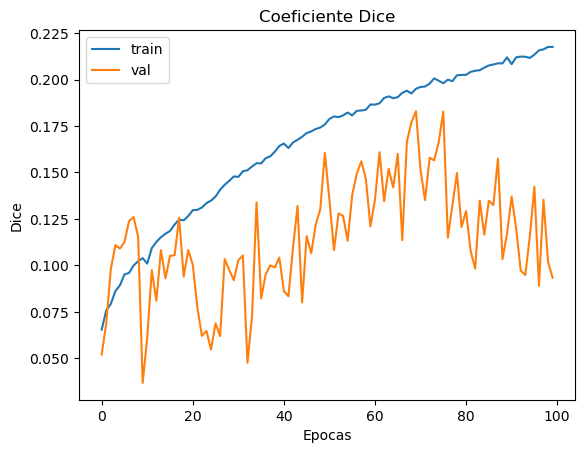

In [18]:
plt.plot(results.history['dicemon'])
plt.plot(results.history['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Epocas')
# plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
predict_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 6s 415ms/step


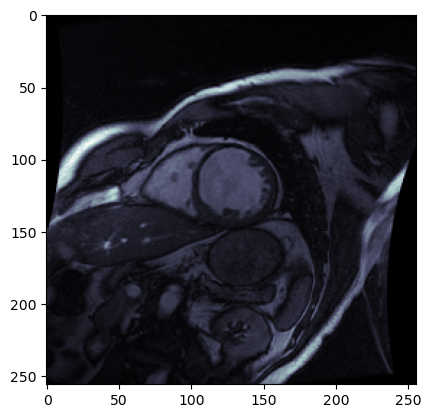

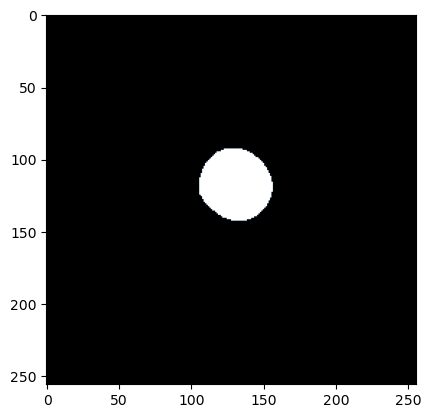

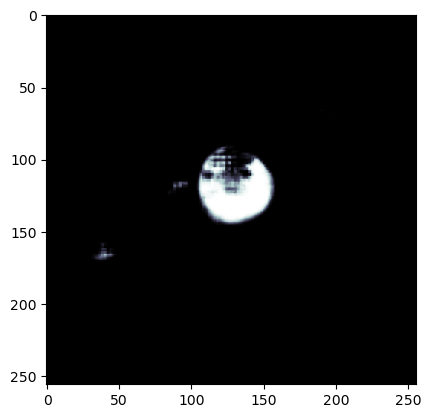

In [47]:
# Ver exemplos de imagens
exemplo = 27

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


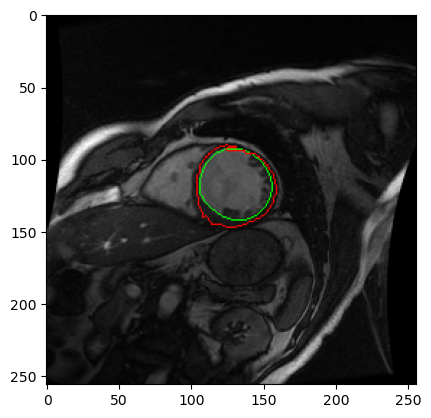

In [48]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = img_as_ubyte(mask)
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img2 = mascara[ind]   
    img3 = add_mascara(img1, img2, (0, 255, 0))
    
    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

dicom = X_test[exemplo]
mascara_gt = Y_test[exemplo]
mascara_p = predict_test[exemplo]

dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

In [49]:
from skimage.segmentation import morphological_chan_vese

def ctr_inicial(mascara):
    mask = mascara.copy()
    mask = img_as_ubyte(mask)
    
    contornos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contornos) > 0:
        ctrs = [len(ctr) for ctr in contornos]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contornos[max_ctr]])
        return pontos
    
    return contornos    

def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))

    return _store

def seg_chan_vese(scan, contorno_inicial, evolution):
    callback = store_evolution_in(evolution)
    ls = morphological_chan_vese(scan, iterations=100, init_level_set=contorno_inicial,
                             smoothing=3, iter_callback=callback)

    return ls.astype(np.float64)

def plot_seg_chan_vese(scan, chan_vese, evolution):
    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax = axes.flatten()
    
    ax[0].imshow(scan, cmap="gray")
    ax[0].set_axis_off()
    ax[0].contour(chan_vese, [0.5], colors='b')
    ax[0].set_title("Morphological GAC segmentation", fontsize=12)
    
    ax[1].imshow(chan_vese, cmap="gray")
    ax[1].set_axis_off()
    contour = ax[1].contour(evolution[0], [0.5], colors='r')
    contour.collections[0].set_label("Starting Contour")
    contour = ax[1].contour(evolution[5], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 5")
    contour = ax[1].contour(evolution[-1], [0.5], colors='b')
    contour.collections[0].set_label("Last Iteration")
    ax[1].legend(loc="upper right")
    title = "Morphological ACWE Curve evolution"
    ax[1].set_title(title, fontsize=12)
    plt.show()

In [50]:
import skimage.segmentation as seg

def seg_snakes(scan, contorno_inicial):
    # Segmentação contorno ativo (snakes)    
    snakes = seg.active_contour(scan, contorno_inicial, alpha=0.05)
    return snakes
    
def plot_seg_snakes(scan, contorno, snakes, circulo):
    fig, ax = plt.subplots()
    ax.imshow(scan, cmap=plt.cm.bone)
    # Circulo passado
    ax.plot(circulo[:, 0], circulo[:,1], '--g', lw=3)
    # Contorno detectado
    ax.plot(snakes[:,0], snakes[:,1], '-b', lw=3)
    # Ground-Truth
    ax.plot([gt[0] for gt in contorno], [gt[1] for gt in contorno], '-r', lw=3)
    plt.show()


In [51]:
import skimage.draw as draw

def seg_random_walker(data_training_img, circulo):
    #Random Walker
    image_labels = np.zeros(data_training_img.shape, dtype=np.uint8)
    
    indices = draw.circle_perimeter(140, 140, 10)
    
    image_labels[indices] = 1
    image_labels[circulo[:, 1].astype(np.int), circulo[:, 0].astype(np.int)] = 2
    
    random_walker_seg = seg.random_walker(data_training_img, image_labels, beta=10, mode='bf')
    return random_walker_seg
    
def plot_random_walker(scan, contorno, random_walker_seg):
    fig, ax = plt.subplots()
    ax.imshow(scan, cmap=plt.cm.bone)
    ax.imshow(random_walker_seg == 1, alpha=0.3)
    ax.plot([gt[0] for gt in contorno], [gt[1] for gt in contorno], '-r', lw=3)
    plt.show()

In [52]:
from skimage.color import rgb2gray

snakes = []
random_walk = []
ci = []
chan_vese = []
evolution_cv = [[]] * len(X_test) 
for n, scan in tqdm(enumerate(X_test), total=len(X_test)):
    ci = ctr_inicial(np.squeeze(predict_test[n]))
    mask_bit = np.empty((256, 256))
    cv2.drawContours(mask_bit, np.array([ci]), 0, 255, cv2.FILLED)
    mask_bit = np.where(mask_bit>128, 1.0, 0.0)
    
    
    img1 = np.uint8(cv2.normalize(np.squeeze(scan), None, 0, 255, cv2.NORM_MINMAX))
    clahe = cv2.createCLAHE(clipLimit=0.9, tileGridSize=(1,1))
    gimage = clahe.apply(img1) / 255
    

    sn = seg_snakes(gimage, ci)
    snake_mask = np.empty((256, 256))
    cv2.drawContours(snake_mask, np.array([sn.astype(int)]), 0, 255, cv2.FILLED)
    snake_mask = np.where(mask_bit>128, 1.0, 0.0)
    snakes.append(snake_mask)
    
    rw = seg_random_walker(gimage, ci)
    random_walk.append(rw)
    
    chan_vese.append(seg_chan_vese(gimage, mask_bit, evolution_cv[n]))
    

100%|██████████| 161/161 [07:08<00:00,  2.66s/it]


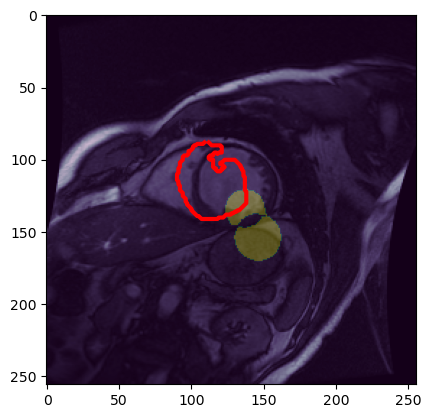

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado Random Walker


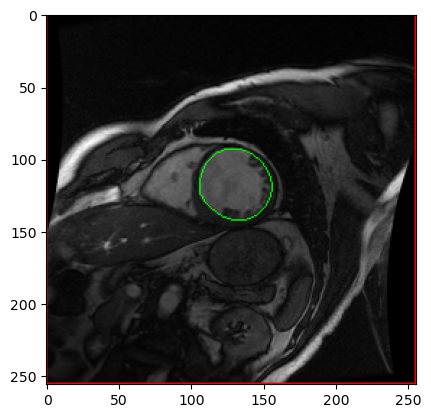

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado Snakes


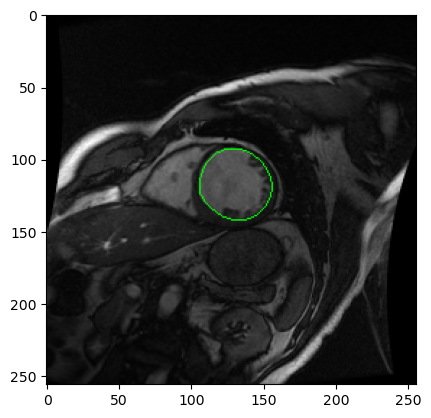

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado Chan-vese


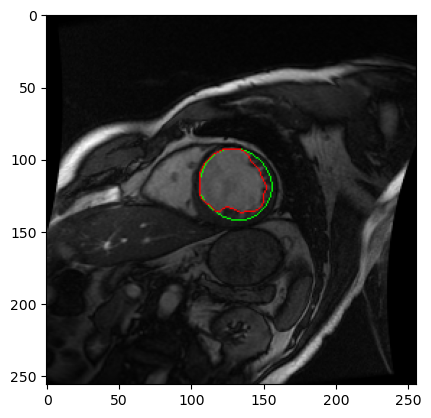

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado


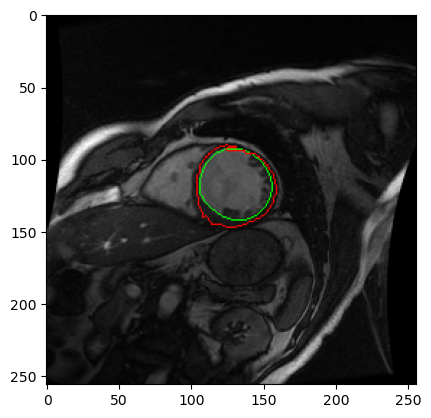

In [103]:
plot_random_walker(X_test[exemplo], ci, random_walk[exemplo])

print("Resultado Random Walker")
res_rw = marcar_ground_truth(exemplo, X_test, Y_test)
res_rw = marcar_predict(exemplo, res_rw, random_walk)
plt.imshow(res_rw)
plt.show()


print("Resultado Snakes")
res_snake = marcar_ground_truth(exemplo, X_test, Y_test)
res_snake = marcar_predict(exemplo, res_snake, snakes)
plt.imshow(res_snake)
plt.show()

print("Resultado Chan-vese")
res_chan_vese = marcar_ground_truth(exemplo, X_test, Y_test)
res_chan_vese = marcar_predict(exemplo, res_chan_vese, chan_vese)
plt.imshow(res_chan_vese)
plt.show()

print("Resultado")
res_pred = marcar_ground_truth(exemplo, X_test, Y_test)
res_pred = marcar_predict(exemplo, res_pred, predict_test)
plt.imshow(res_pred)
plt.show()

In [108]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix


def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))


def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    for i in range(batch_size):
        channel_dice = single_dice_coef(y_true[i], y_pred_bin[i])
        mean_dice_channel += channel_dice/batch_size
    return mean_dice_channel


# def generate_metrics(title, y_pred_model):
#     cfm_plot = plot_confusion_matrix(model, X_test, Y_test)
# #     cnf_matrix = metrics.confusion_matrix(Y_test, y_pred_model)
# #     tn, fp = cnf_matrix[0] 
# #     fn, tp = cnf_matrix[1]
# #     print(title, "Metrics:")

# #     print("Accuracy:",(tp+tn)/(tn+tp+fn+fp)) # (TP + TN)/(TOTAL)
# #     print("Precision:",tp/(tp+fp)) # TP/(TP+FP)
# #     print("Recall/Sensitivity:",tp/(tp+fn)) # TP/(TP+FN) 
# #     print("Specificity:",tn/(tn+fp), "\n"); # TN/(TN + FP)

# # generate_metrics("Decision tree", predict_test)
# generate_metrics("Logistic Regression", np.array(chan_vese))
print(Y_test.shape)
print(np.array(chan_vese).shape)
print(predict_test.shape)
print("Chan vese: ", mean_dice_coef(np.squeeze(Y_test), np.array(chan_vese)))
print("Snakes: ", mean_dice_coef(np.squeeze(Y_test), np.array(snakes)))
print("Random Walk: ", mean_dice_coef(np.squeeze(Y_test), np.array(random_walk)))

(161, 256, 256, 1)
(161, 256, 256)
(161, 256, 256, 1)
Chan vese:  0.48537196657188947
Snakes:  0.0
Random Walk:  0.02967175531668151


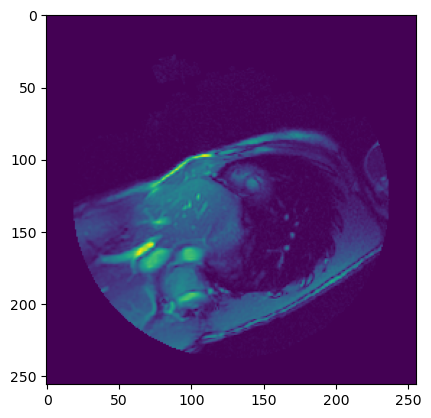

np.max(mask_bit):  1.0 np.max(predict_test):  0.84485435


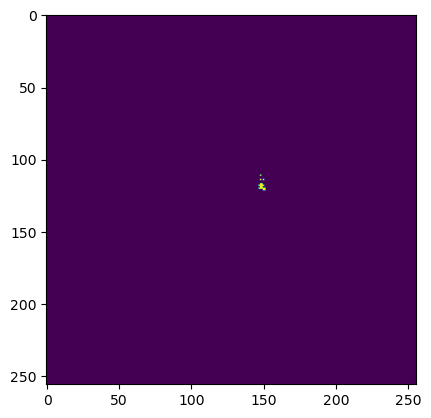

<ipython-input-120-e61114727f05>:44: UserWarning: No contour levels were found within the data range.
  ax[0].contour(ls, [0.5], colors='b')
<ipython-input-120-e61114727f05>:53: UserWarning: No contour levels were found within the data range.
  contour = ax[1].contour(evolution[-1], [0.5], colors='b')


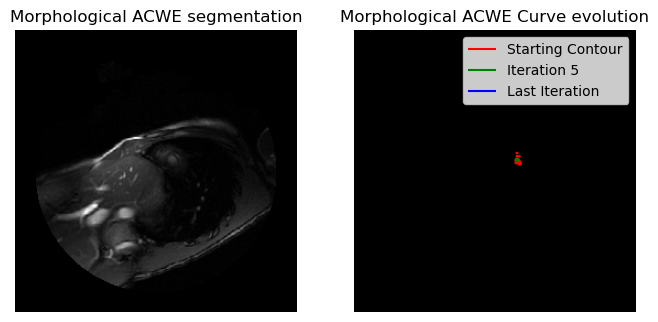

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Chan vese


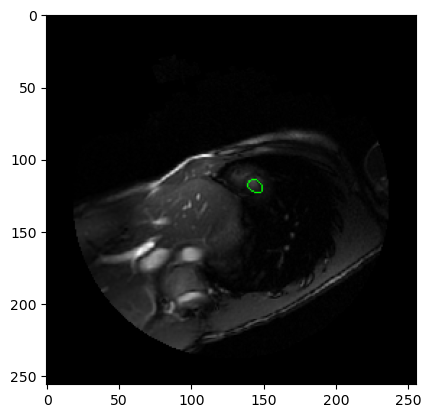

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado


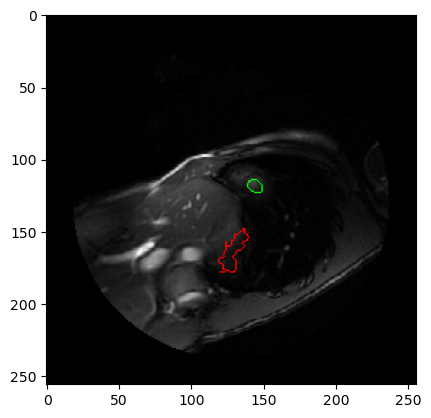

In [120]:
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient, morphological_chan_vese
from skimage import exposure
from skimage.filters import gaussian
from skimage import img_as_float

dicom_rgb = np.squeeze(X_test[exemplo])
gimage = dicom_rgb
exemplo = 14
# gimage = inverse_gaussian_gradient(gimage)
# gimage = gaussian(gimage)

# p2, p98 = np.percentile(gimage, (2, 98))
# gimage = exposure.rescale_intensity(gimage, in_range=(p2, p98))


img1 = np.uint8(cv2.normalize(gimage, None, 0, 255, cv2.NORM_MINMAX))
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=0.9, tileGridSize=(1,1))
gimage = clahe.apply(img1) / 255


plt.imshow(gimage)
plt.show()

bw = np.squeeze(predict_test[exemplo]).copy()
mask_bit = img_as_ubyte(bw)
mask_bit = np.where(mask_bit>128, 1.0, 0.0)
print("np.max(mask_bit): ", np.max(mask_bit), "np.max(predict_test): ", np.max(predict_test[exemplo]))
plt.imshow(mask_bit)
plt.show()

evolution = []
callback = store_evolution_in(evolution)

ls = morphological_chan_vese(gimage, iterations=100, init_level_set=mask_bit,
                             smoothing=3, iter_callback=callback)


fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(dicom_rgb, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='b')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='r')
contour.collections[0].set_label("Starting Contour")
contour = ax[1].contour(evolution[5], [0.5], colors='g')
contour.collections[0].set_label("Iteration 5")
contour = ax[1].contour(evolution[-1], [0.5], colors='b')
contour.collections[0].set_label("Last Iteration")
ax[1].legend(loc="upper right")
title = "Morphological ACWE Curve evolution"
ax[1].set_title(title, fontsize=12)

plt.show()

print("Chan vese")
dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = add_mascara(dicom2, ls, (255, 0, 0))
plt.imshow(dicom2)
plt.show()


print("Resultado")
dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

indice:  62


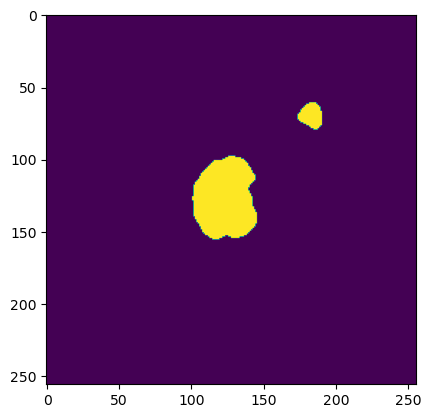

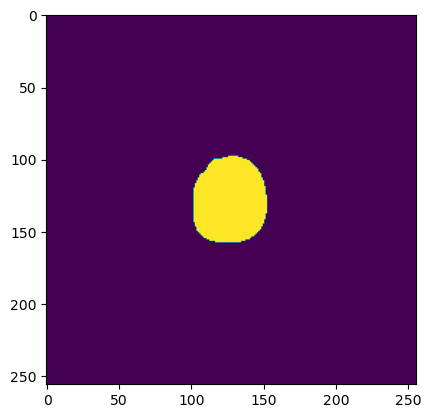

In [116]:
ex_test = random.randint(0, 160)
print("indice: ", ex_test)
plt.imshow(chan_vese[ex_test])
plt.show()

plt.imshow(Y_test[ex_test])
plt.show()

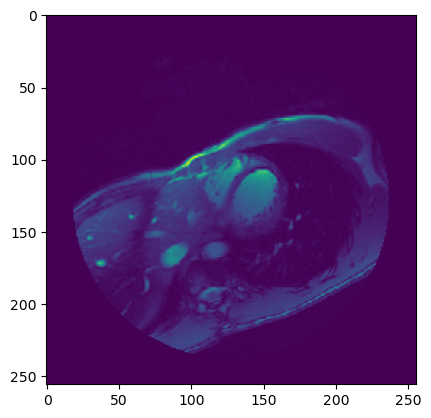

In [127]:
y_true = np.squeeze(Y_test)[0]
y_pred = np.array(chan_vese)[0]

# shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
# batch_size = y_true.shape[0]
# print(batch_size)
# mean_dice_channel = 0.
# for i in range(batch_size):
#     print(y_true[i].shape)
#     channel_dice = dice_coef(y_true[i], y_pred_bin[i])
#     mean_dice_channel += channel_dice/batch_size

fft_img_2d = np.fft.fftn(X_train[0])
plt.imshow(np.abs(np.fft.ifftn(fft_img_2d)))
plt.show()